# Correlation and Interaction Analysis

Contributors: Brooks Piper, Sam Caruthers, Alex Dieter, Alex Morifusa, Bahaar Ahuja

## Data Importation, Cleaning, and EDA

In [3]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm

In [4]:
# import data
csv_url = 'https://raw.githubusercontent.com/pstat197/BlueAlpha3-Synergy-Analysis/refs/heads/main/data/monthly_mocha.csv'
mocha_subscriptions = pd.read_csv(csv_url)

# Identify columns with all zero values
zero_value_columns = [col for col in mocha_subscriptions.columns if (mocha_subscriptions[col] == 0).all()]

if zero_value_columns:
    # Drop the identified columns
    mocha_subscriptions = mocha_subscriptions.drop(columns=zero_value_columns)
    print(f"Dropped columns with all zero values: {zero_value_columns}")
else:
    print("No columns with all zero values found.")

display(mocha_subscriptions.head())

Dropped columns with all zero values: ['roku_spend', 'roku_impressions']


,date,subscriptions,meta_spend,meta_impressions,google_spend,google_impressions,snapchat_spend,snapchat_impressions,tiktok_spend,tiktok_impressions,moloco_spend,moloco_impressions,liveintent_spend,liveintent_impressions,beehiiv_spend,beehiiv_impressions,amazon_spend,amazon_impressions
0,8/4/25,15540,91538.06648,16572258,116667.9945,6473132,94750.04035,3420454,0.0,0,6564.524233,367206,37766.44904,371854,18190.10332,181901,0.0,0
1,7/28/25,14525,93840.18612,25300600,180486.9558,9487127,99447.23218,3235285,0.0,0,18111.083980,820589,38543.27888,347850,20063.91811,200639,0.0,0
2,7/21/25,16880,48403.06780,14099214,200817.3250,7909118,84738.57435,4766750,0.0,0,9714.794608,369806,39697.42202,322865,20828.00074,208280,0.0,0
3,7/14/25,20113,49470.96783,13652072,215770.9242,7789279,83204.40500,4022680,0.0,0,16831.841440,554980,40561.34006,570418,24097.34426,240973,0.0,0
4,7/7/25,16492,48948.28744,10121002,209231.9668,6806878,82642.37271,4532105,0.0,0,17624.908800,894891,40012.42040,483619,19967.60420,199676,0.0,0


/var/folders/hj/ss74h5m100j0j4b3f9n9tknh0000gn/T/ipykernel_81332/2506076539.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mocha_subscriptions["date"] = pd.to_datetime(mocha_subscriptions["date"])


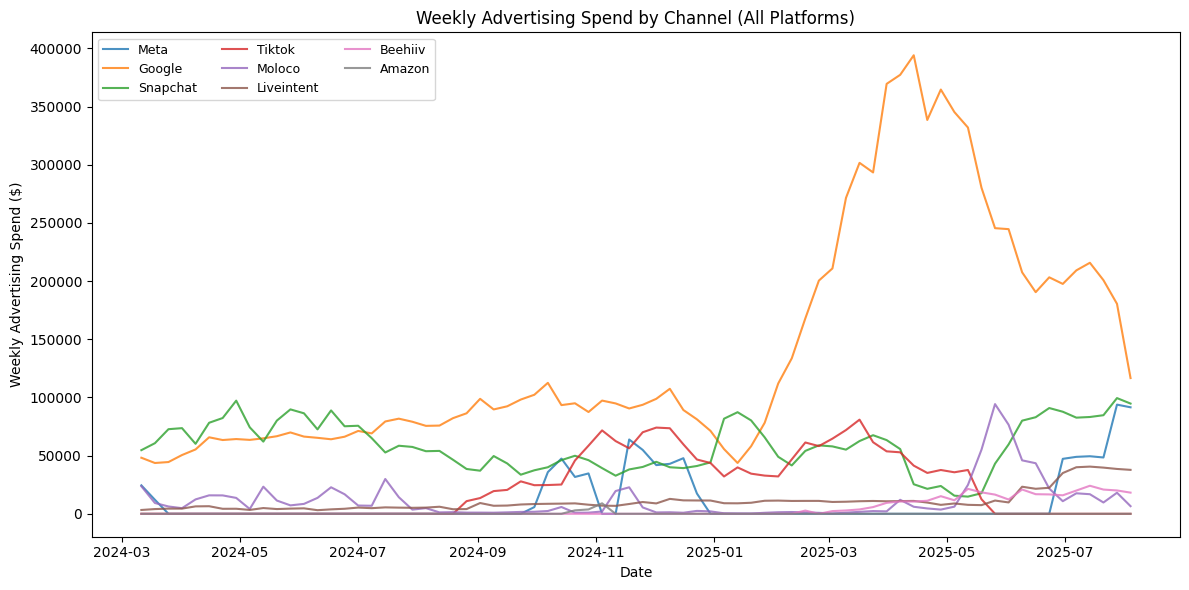

In [5]:
# Ensure date is datetime
mocha_subscriptions["date"] = pd.to_datetime(mocha_subscriptions["date"])

# Select all spend columns
spend_cols = [c for c in mocha_subscriptions.columns if c.endswith("_spend")]

plt.figure(figsize=(12, 6))

for col in spend_cols:
    plt.plot(
        mocha_subscriptions["date"],
        mocha_subscriptions[col],
        label=col.replace("_spend", "").title(),
        alpha=0.8
    )

plt.xlabel("Date")
plt.ylabel("Weekly Advertising Spend ($)")
plt.title("Weekly Advertising Spend by Channel (All Platforms)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

We are working with time series data for several marketing channels:
1. Meta
2. TikTok
3. BeeHiiv
4. Google
5. Moloco
6. Amazon
7. Snapchat
8. LiveIntent

Google has the highest spend by a significant amount, while the remaining seven channels all remain between the \$0 and \$100000 range. Focusing on potential interactions, there appear spikes around November, 2024 and May, 2025 where spending follows an increasing trend for many channels, suggesting that interactions are present.

## Pairwise Correlation Heatmap

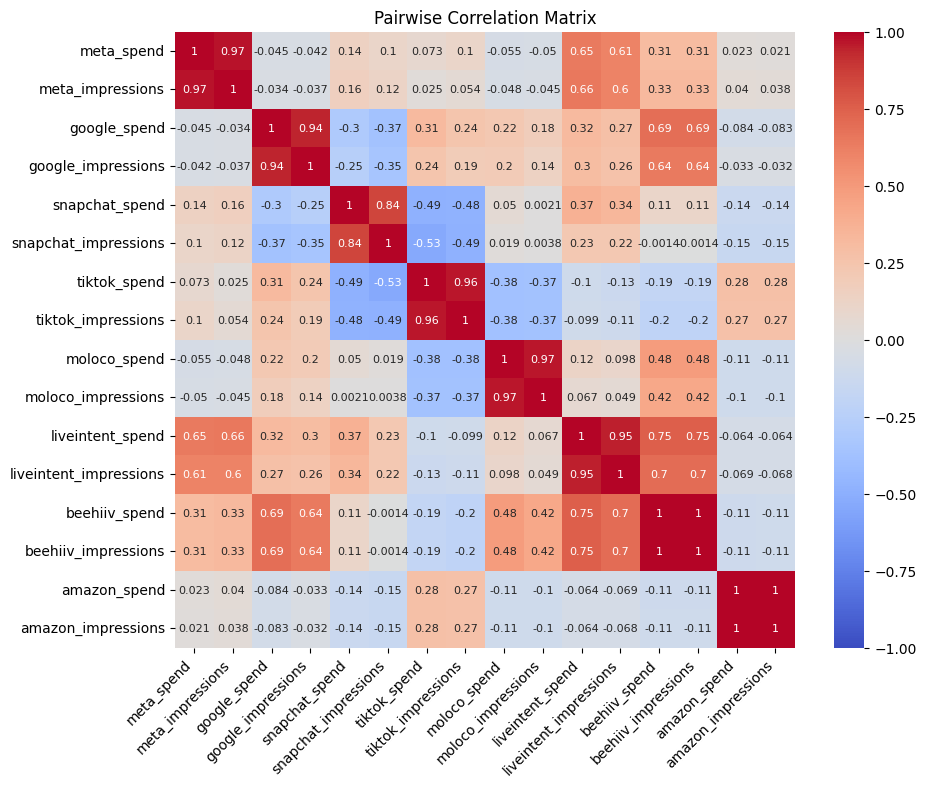

In [6]:
# drop response variable for heatmap and VIF
corr_data = mocha_subscriptions.drop(columns=['subscriptions', 'date'])

# Compute the pairwise correlation matrix
corr_matrix = corr_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"fontsize": 8})
plt.title('Pairwise Correlation Matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

### Heatmap Results

The pairwise correlation heatmap reveals several channel pairs with potential interactions. Some of these are:

* Meta and LiveIntent
* Google and Beehiiv
* Snapchat and TikTok
* LiveIntent and BeeHiiv

This list is not extensive nor ridgedly constructed. Furthermore, these pairs are *theorized* to be interacting based upon an arbitrary correlation cutoff. Further and more sophisticated causality testing will need to be used in order to determine if they will fit well within the model.

## Variance Inflation Factor (VIF)

In [7]:
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_data.columns

vif_data["VIF"] = [variance_inflation_factor(corr_data.values, i)
                          for i in range(len(corr_data.columns))]
vif_data

,Feature,VIF
0,meta_spend,3.323567e+01
1,meta_impressions,3.069986e+01
2,google_spend,8.747860e+01
3,google_impressions,4.116332e+01
4,snapchat_spend,3.722198e+01
5,snapchat_impressions,3.009011e+01
6,tiktok_spend,4.569125e+01
7,tiktok_impressions,3.052867e+01
8,moloco_spend,3.297831e+01
9,moloco_impressions,3.084501e+01


### Variance Inflation Factor Results

Upon calculating the Variance Inflation Factor for all channels, we find all values are above 10. These results indicate a strong presence of multicollinearity, reinforcing our previous intuition that interactions are present among the channels.

## Residual Analysis

In [8]:
target = "subscriptions"
channels = ["meta_spend", "google_spend", "snapchat_spend"]

X = mocha_subscriptions[channels]
y = mocha_subscriptions[target]

model = LinearRegression()
model.fit(X, y)

mocha_subscriptions["prediction"] = model.predict(X)
mocha_subscriptions["residual"] = y - mocha_subscriptions["prediction"]

results = []

for ch in channels:
    pearson_corr, pearson_p = pearsonr(mocha_subscriptions["residual"], mocha_subscriptions[ch])
    spearman_corr, spearman_p = spearmanr(mocha_subscriptions["residual"], mocha_subscriptions[ch])

    results.append({
        "channel": ch,
        "pearson_corr": pearson_corr,
        "pearson_p": pearson_p,
        "spearman_corr": spearman_corr,
        "spearman_p": spearman_p
    })

results_df = (
    pd.DataFrame(results)
      .sort_values("pearson_corr", ascending=False)
)

results_df

,channel,pearson_corr,pearson_p,spearman_corr,spearman_p
0,meta_spend,-1.595946e-16,1.0,-0.010088,0.932020
2,snapchat_spend,-1.838807e-16,1.0,-0.004132,0.972129
1,google_spend,-7.355228e-16,1.0,0.064672,0.584080


### Residual Diagnostic Results
Examining Pearson and Spearman correlations between model residuals and individual channel spends as standard diagnostic checks for misspecification or omitted structure. Across all channels, correlations are effectively zero with very high p-values, indicating no statistically significant linear or monotonic dependence between residuals and channel inputs. This suggests that the model has absorbed the systematic channel-level signal, leaving residual variation consistent with noise rather than unmodeled effects.

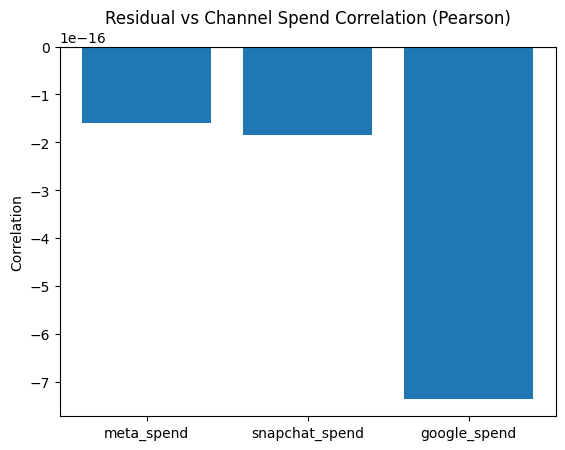

In [9]:
plt.figure()
plt.bar(results_df["channel"], results_df["pearson_corr"])
plt.axhline(0)
plt.ylabel("Correlation")
plt.title("Residual vs Channel Spend Correlation (Pearson)")
plt.show()

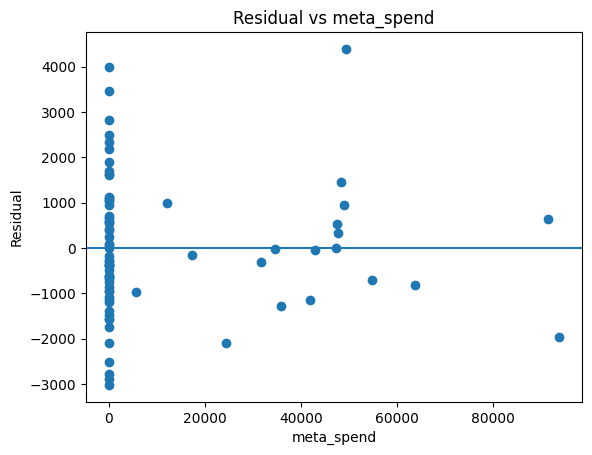

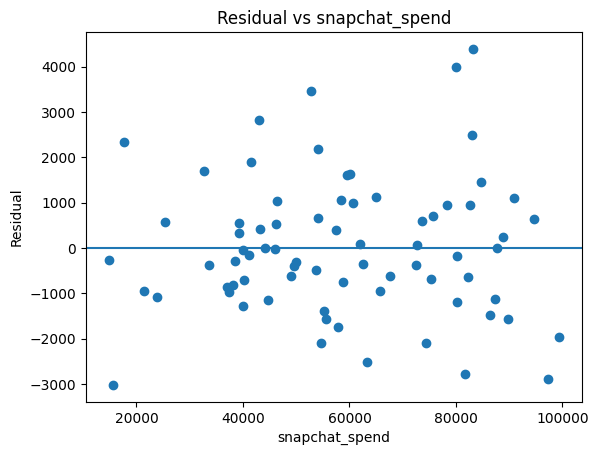

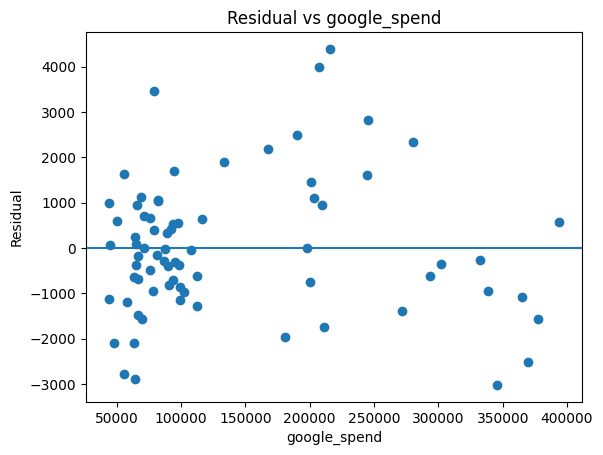

In [10]:
top_channels = results_df["channel"]

for ch in top_channels:
    plt.figure()
    plt.scatter(mocha_subscriptions[ch], mocha_subscriptions["residual"])
    plt.axhline(0)
    plt.xlabel(ch)
    plt.ylabel("Residual")
    plt.title(f"Residual vs {ch}")
    plt.show()

In [11]:
for ch in channels:
    corr, p = pearsonr(mocha_subscriptions["residual"].iloc[1:], mocha_subscriptions[ch].shift(1).iloc[1:])
    print(f"{ch} (lagged): corr={corr:.3f}, p={p:.3f}")

meta_spend (lagged): corr=0.058, p=0.626
google_spend (lagged): corr=-0.021, p=0.857
snapchat_spend (lagged): corr=0.173, p=0.143


Lagged Pearson correlation tests indicate no statistically significant dependence between model residuals and one-period–lagged channel spends suggesting that short-run dynamic effects are adequately captured by the model.

In [12]:
# --- Residual Diagnostics ---
# Use spends only (common MMM baseline diagnostic)
spend_cols = [c for c in mocha_subscriptions.columns if c.endswith('_spend')]

# Drop all-zero spend columns (e.g., roku_spend)
spend_cols = [c for c in spend_cols if not (mocha_subscriptions[c] == 0).all()]

X = mocha_subscriptions[spend_cols]
y = mocha_subscriptions['subscriptions']

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()

mocha_subscriptions['fitted'] = ols.predict(X)
mocha_subscriptions['residuals'] = y - mocha_subscriptions['fitted']

print(f"R^2 of full model (all spend channels): {ols.rsquared}")

R^2 of full model (all spend channels): 0.8196205028065111


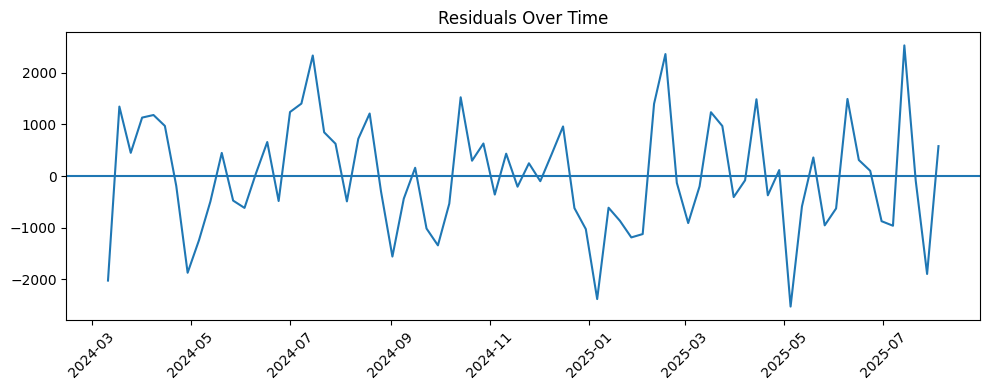

In [13]:
# 1) Residuals over time
plt.figure(figsize=(10,4))
plt.plot(mocha_subscriptions['date'], mocha_subscriptions['residuals'])
plt.axhline(0)
plt.title("Residuals Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

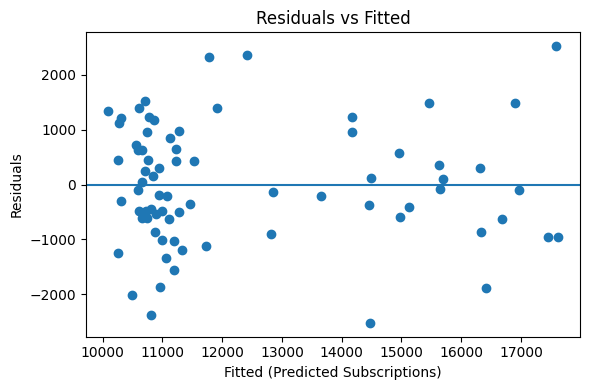

In [14]:
# 2) Residuals vs fitted
plt.figure(figsize=(6,4))
plt.scatter(mocha_subscriptions['fitted'], mocha_subscriptions['residuals'])
plt.axhline(0)
plt.xlabel("Fitted (Predicted Subscriptions)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.tight_layout()
plt.show()


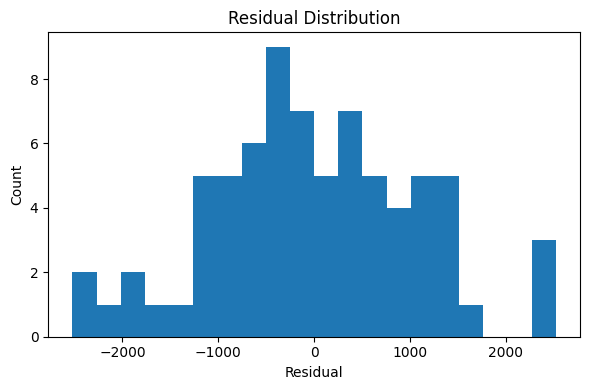

In [15]:

# 3) Residual distribution
plt.figure(figsize=(6,4))
plt.hist(mocha_subscriptions['residuals'], bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



liveintent_spend    3.470402e-15
snapchat_spend      3.408057e-15
beehiiv_spend       3.025781e-15
meta_spend          2.468413e-15
moloco_spend        2.377794e-15
google_spend       -1.620827e-16
amazon_spend       -1.679437e-15
tiktok_spend       -3.998320e-15
dtype: float64


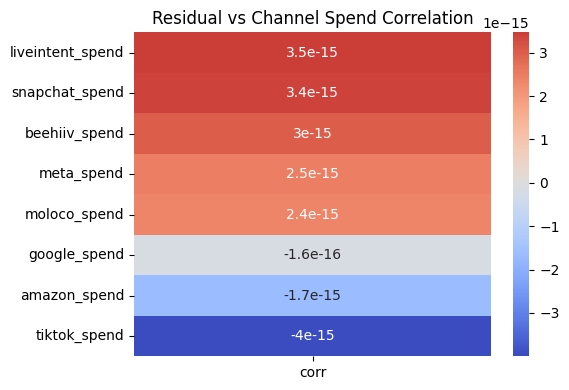

In [16]:
# 4) Correlation of residuals with spend (ranked + heatmap)
resid_corr = (
    mocha_subscriptions[spend_cols]
    .corrwith(mocha_subscriptions['residuals'])
    .sort_values(ascending=False)
)

print(resid_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(resid_corr.to_frame("corr"), annot=True, cmap="coolwarm", center=0)
plt.title("Residual vs Channel Spend Correlation")
plt.tight_layout()
plt.show()

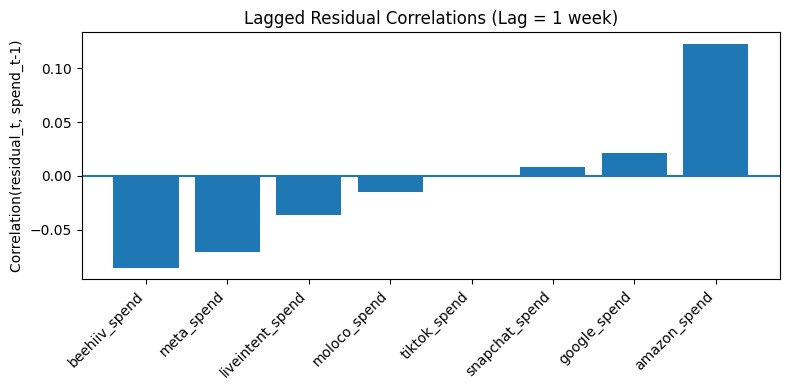

beehiiv_spend      -0.085906
meta_spend         -0.070514
liveintent_spend   -0.036636
moloco_spend       -0.015419
tiktok_spend       -0.001482
snapchat_spend      0.008224
google_spend        0.021714
amazon_spend        0.123148
dtype: float64

In [17]:
# --- settings ---
lag = 1  # try 1, 2, 3 (weeks)
spend_cols = [c for c in mocha_subscriptions.columns if c.endswith("_spend")]
spend_cols = [c for c in spend_cols if not (mocha_subscriptions[c] == 0).all()]  # drop all-zero channels

# --- compute lagged correlations ---
lag_corr = {}

resid = mocha_subscriptions["residuals"]

for col in spend_cols:
    spend_lagged = mocha_subscriptions[col].shift(lag)

    # Align and drop NaNs introduced by shifting
    valid = pd.concat([resid, spend_lagged], axis=1).dropna()
    r = np.corrcoef(valid.iloc[:, 0], valid.iloc[:, 1])[0, 1]
    lag_corr[col] = r

lag_corr_s = pd.Series(lag_corr).sort_values()

# --- plot (slide-friendly) ---
plt.figure(figsize=(8, 4))
plt.bar(lag_corr_s.index, lag_corr_s.values)
plt.axhline(0)
plt.xticks(rotation=45, ha="right")
plt.ylabel(f"Correlation(residual_t, spend_t-{lag})")
plt.title(f"Lagged Residual Correlations (Lag = {lag} week)")
plt.tight_layout()
plt.show()

# also display the numbers
lag_corr_s


In [18]:
from scipy.stats import pearsonr
import pandas as pd

lag = 1
results = []

for col in spend_cols:
    spend_lagged = mocha_subscriptions[col].shift(lag)
    valid = pd.concat(
        [mocha_subscriptions["residuals"], spend_lagged],
        axis=1
    ).dropna()

    r, p = pearsonr(valid.iloc[:, 0], valid.iloc[:, 1])
    results.append([col, r, p])

lag_test_df = pd.DataFrame(
    results,
    columns=["channel", "lagged_corr", "p_value"]
).sort_values("p_value")

lag_test_df


,channel,lagged_corr,p_value
7,amazon_spend,0.123148,0.299282
6,beehiiv_spend,-0.085906,0.469896
0,meta_spend,-0.070514,0.553307
5,liveintent_spend,-0.036636,0.758294
1,google_spend,0.021714,0.855312
4,moloco_spend,-0.015419,0.896982
2,snapchat_spend,0.008224,0.944948
3,tiktok_spend,-0.001482,0.990070


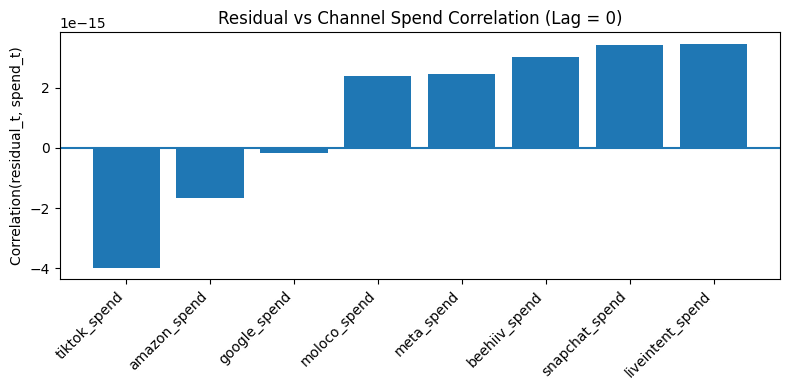

tiktok_spend       -3.998320e-15
amazon_spend       -1.679437e-15
google_spend       -1.620827e-16
moloco_spend        2.377794e-15
meta_spend          2.468413e-15
beehiiv_spend       3.025781e-15
snapchat_spend      3.408057e-15
liveintent_spend    3.470402e-15
dtype: float64

In [19]:
# Identify spend columns
spend_cols = [c for c in mocha_subscriptions.columns if c.endswith("_spend")]
spend_cols = [c for c in spend_cols if not (mocha_subscriptions[c] == 0).all()]

# Compute same-week (lag = 0) residual correlations
lag0_corr = {}

for col in spend_cols:
    valid = pd.concat(
        [mocha_subscriptions["residuals"], mocha_subscriptions[col]],
        axis=1
    ).dropna()

    r = np.corrcoef(valid.iloc[:, 0], valid.iloc[:, 1])[0, 1]
    lag0_corr[col] = r

lag0_corr_s = pd.Series(lag0_corr).sort_values()

# Plot
plt.figure(figsize=(8, 4))
plt.bar(lag0_corr_s.index, lag0_corr_s.values)
plt.axhline(0)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlation(residual_t, spend_t)")
plt.title("Residual vs Channel Spend Correlation (Lag = 0)")
plt.tight_layout()
plt.show()

lag0_corr_s


## Ridge regression

Because we have multicollinearity among the channels, we try Ridge regression to get more stable coefficients. Ridge shrinks the coefficients so they don't blow up when predictors are correlated.


Ridge coefficients (sorted by size):
         channel  ridge_coef
liveintent_spend    0.142275
    amazon_spend    0.069131
    moloco_spend    0.043986
    google_spend    0.013099
      meta_spend   -0.012581
  snapchat_spend    0.005618
   beehiiv_spend    0.002330
    tiktok_spend   -0.001313

R² Ridge: 0.8196   R² OLS: 0.8196


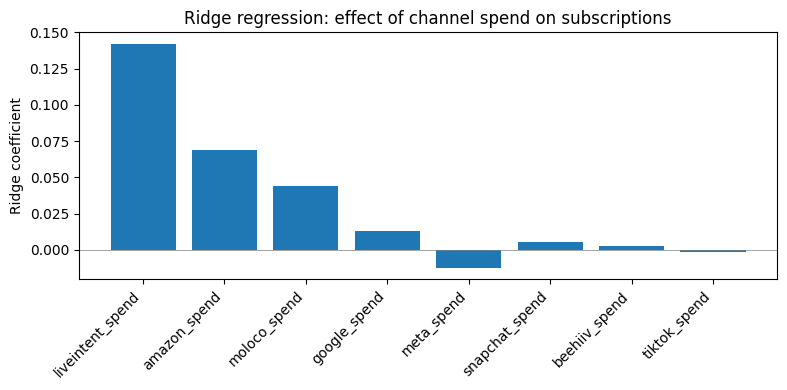

In [21]:
spend_cols = [c for c in mocha_subscriptions.columns if c.endswith("_spend")]
spend_cols = [c for c in spend_cols if not (mocha_subscriptions[c] == 0).all()]

X = mocha_subscriptions[spend_cols]
y = mocha_subscriptions["subscriptions"]

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(X, y)

coef_df = pd.DataFrame({"channel": spend_cols, "ridge_coef": ridge.coef_})
coef_df = coef_df.sort_values("ridge_coef", key=abs, ascending=False)
print("Ridge coefficients (sorted by size):")
print(coef_df.to_string(index=False))

ols_same = LinearRegression().fit(X, y)
ols_coefs = dict(zip(spend_cols, ols_same.coef_))
coef_df["ols_coef"] = coef_df["channel"].map(ols_coefs)
print("\nR² Ridge:", round(ridge.score(X, y), 4), "  R² OLS:", round(ols_same.score(X, y), 4))

plt.figure(figsize=(8, 4))
plt.bar(coef_df["channel"], coef_df["ridge_coef"])
plt.axhline(0, color="gray", linewidth=0.5)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Ridge coefficient")
plt.title("Ridge regression: effect of channel spend on subscriptions")
plt.tight_layout()
plt.show()


LiveIntent and Amazon spend have the strongest positive association with subscriptions in this Ridge model; Meta is slightly negative likely because of correlation with others; the rest are small.
R² Ridge = R² OLS = 0.8196
Both models explain about 82% of the variation in subscriptions. Ridge isn’t fitting the data better; it’s giving more stable coefficients when channels are correlated. So the “meaning” is: same fit, but Ridge’s coefficients are the ones that are safer to compare across channels.

## Results

**Heatmap**:
We produced a pairwise correlation matrix, or heatmap, that visualized potential interactions between channels. Many pairs, such as Meta and LiveIntent, Google and BeeHiiv, and Snapchat and Tiktok, were highly correlated, supporting the theory that channel spend and impression are linked.

**Variance Inflation Factor**:
We calculated the Variance Inflation Factor (VIF) for all channels, all of which were above 10. These results point to the presence of multicollinearity among the channels.

**Residuals**:
We examined whether model residuals are correlated with contemporaneous or lagged channel spend as a diagnostic for omitted cross-channel or dynamic effects. Across all channels, correlations are small and statistically insignificant, indicating no evidence of systematic dependence between residuals and channel inputs.


**Limitations**:
We only have a limited number of weeks in the data, and for some channels (like Meta) spend is only non-zero in the last few weeks. That makes our correlation and regression estimates less stable. We also dropped channels that had all zeros (e.g. Roku, TikTok in this sample), so what we say here only applies to channels that actually had some spend. Finally, high correlations mean things move together—they don't tell us that one thing caused the other. Other stuff (like when the company decides to spend more overall) could be driving both.

**Recommendations**:
Because of the multicollinearity we found, we shouldn't put too much weight on individual coefficients from a single regression that has all channels in it. It would be better to try something like Ridge regression or to use fewer predictors if we want to say which channel is doing what. Getting more data, especially for channels that only recently turned on, would help. If we care about lag or carryover effects, we could add lagged spend terms to the model instead of only checking if residuals are correlated with past spend.